# Partial Correlations and Directed Acyclic Graphs

In [1]:
import random
import numpy as np
import pandas as pd

import numpy as np
import pandas as pd
length = 1000
cols = ["Q", "X", "Y", "Z"]
mu = 0
sigma = 10


import pingouin
lst_dct = {col:[] for col in cols }
for i in range(length):
    lst_dct["Q"].append(50 + np.random.normal(mu, sigma))
    lst_dct["X"].append(2 * lst_dct["Q"][-1] + 10 + np.random.normal(mu, sigma ))
    lst_dct["Y"].append(lst_dct["Q"][-1] * -3 + 2 * lst_dct["X"][-1] + 20 +  np.random.normal(mu, sigma))
    lst_dct["Z"].append(.5 * lst_dct["X"][-1] + .5 * lst_dct["Y"][-1] +  np.random.normal(mu, 3 * sigma))

df = pd.DataFrame(lst_dct)
keys = ["X",
        "Y",
        "Z",
        "Q"]
dag_keys = keys 
df

,Q,X,Y,Z
0,38.933933,78.734959,-89.695833,24.304221
1,51.893629,104.735000,-129.019248,-52.744480
2,42.894521,86.632940,-123.114804,20.279247
3,44.809911,95.486498,-101.027075,9.457735
4,60.047382,132.979870,-167.520936,29.607334
...,...,...,...,...
995,46.969477,110.603191,-116.604597,-17.965157
996,42.570345,64.320264,-97.190071,-14.928653
997,42.824705,103.482825,-109.129599,12.170549
998,47.914975,100.419361,-114.569549,-23.579396


Obviously, these variables are correlated. Variables X, Y, and Z all descend from Q. X and Y are direct descendant whereas Z is a descendant of X and Y. We can view all of these correlation in a single plot.

C:\Users\JLCat\anaconda3\lib\site-packages\matplotlib\collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


<AxesSubplot:xlabel='X', ylabel='Y'>

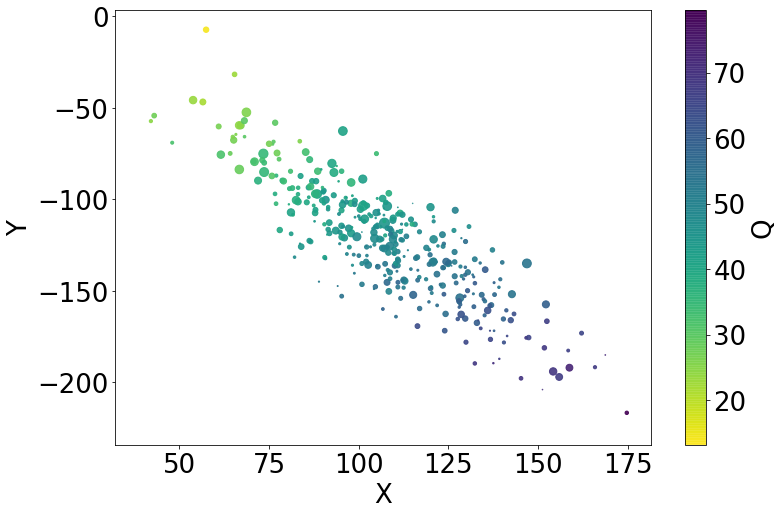

In [2]:
import matplotlib.pyplot as plt
# We can visualize the correlation of these variables on four dimensions:
#     2 dimensions in x-y space, a 3rd dimension using size and a fourth using color
plt.rcParams.update({"font.size":26})
fig, ax = plt.subplots(figsize = (12,8))
df.plot.scatter(x = "X", y = "Y", c = "Q",s = "Z", cmap = "viridis_r",alpha = .9, ax = ax)

In [3]:
df.corr()

,Q,X,Y,Z
Q,1.000000,0.897095,-0.951668,-0.230934
X,0.897095,1.000000,-0.854925,-0.129799
Y,-0.951668,-0.854925,1.000000,0.260668
Z,-0.230934,-0.129799,0.260668,1.000000


# Partial Correlation

All of the variables appear to be correlated. Yet, we should be suspicious of the correlation between Z and Q. Q does not cause Z directly. Its causal effect on Z is intermediated by X and Y. Likewise, X and Y appear to be strongly correlated, but we know that these variables do not cause one another. They have a common cause.

To calculate correlation between two variables while controlling for the effects of the remaining variables, we calculate the partial correlation. For example, the partial correlation of Q and X is an estimate of the joint probability $P(Q,X|Y,Z)$.

In [4]:
import pingouin
df.pcorr()

,Q,X,Y,Z
Q,1.000000,0.523262,-0.790346,-0.047290
X,0.523262,1.000000,-0.034266,0.182903
Y,-0.790346,-0.034266,1.000000,0.140733
Z,-0.047290,0.182903,0.140733,1.000000


We see that the partial correlation of Q and X is 

In [5]:
df[["Q", "X", "Y"]].pcorr()


,Q,X,Y
Q,1.000000,0.524029,-0.805915
X,0.524029,1.000000,-0.008759
Y,-0.805915,-0.008759,1.000000


In [6]:

undirected_graph = {key:[] for key in df.keys()}
for x in undirected_graph:
    remaining_vars = [y for y in df.keys() if y != x]
    for y in remaining_vars:
        undirected_graph[x].append(y)

undirected_graph           

{'Q': ['X', 'Y', 'Z'],
 'X': ['Q', 'Y', 'Z'],
 'Y': ['Q', 'X', 'Z'],
 'Z': ['Q', 'X', 'Y']}

In [7]:
import copy
import pingouin
p_val = .001
def build_skeleton(df, undirected_graph):    
    def check_remaining_controls(control_vars, undirected_graph, x, y, controls_used) :
        c_used = copy.copy(controls_used)
        for c_var in control_vars:
            if y not in undirected_graph[x]:
                break
            c_used.append(c_var)
            test = df.partial_corr(x = x, y = y, covar=c_used,
                                  method = "pearson")
            if test["p-val"].values[0] > p_val: 

                undirected_graph[x].remove(y)
                #breakout of the for 
                break
            else:
                remaining_controls = copy.copy(control_vars)
                remaining_controls.remove(c_var)
                check_remaining_controls(remaining_controls, undirected_graph, x, y, c_used)
    d_sep = {}
    for x in df.keys():
        ys = undirected_graph[x]
        for y in df.keys():
            d_sep[(x,y)] = []

            if x != y:
            # first check for correlation with no controls
                test = df.partial_corr(x = x, y = y, covar = None,method = "pearson") 
                if test["p-val"].values[0] > p_val:
                    undirected_graph[x].remove(y)
            # if correlated check for deseparation controlling for other variables
                else:
                ############## make recursive function #############

                    control_vars = [z for z in df.keys() if z != y and z != x]
                    check_remaining_controls(control_vars, undirected_graph, x, y, [])
    return undirected_graph

undirected_graph = build_skeleton(df, undirected_graph)                                   
undirected_graph

{'Q': ['X', 'Y'], 'X': ['Q', 'Z'], 'Y': ['Q', 'Z'], 'Z': ['X', 'Y']}

In [8]:
import matplotlib.pyplot as plt
import networkx as nx
def graph_DAG(undirected_graph, df, title = "DAG Structure"):
    
    # generate partial correlation matrix to draw values from
    # for graph edges
    pcorr_matrix = df.pcorr()
    graph = nx.Graph()
    edges = []
    edge_labels = {}
    for key in undirected_graph:
        for key2 in undirected_graph[key]:
            if (key2, key) not in edges:
                edge = (key.replace(" ","\n"), key2[0].replace(" ","\n"))
                edges.append(edge)
                # edge label is partial correlation between
                # key and key2
                edge_labels[edge] = str(round(pcorr_matrix.loc[key][key2],2))

    # edge format: ("i", "j") --> from node i to node j
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, 
                     node_size = 1000,
                     with_labels=True,  arrows=False,
                     font_size = 20, alpha = 1,
                     font_color = "white",
                     ax = ax)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20)
    plt.axis("off")
    plt.savefig("g1.png", format="PNG")
    # tell matplotlib you're done with the plot: https://stackoverflow.com/questions/741877/how-do-i-tell-matplotlib-that-i-am-done-with-a-plot
    plt.show()


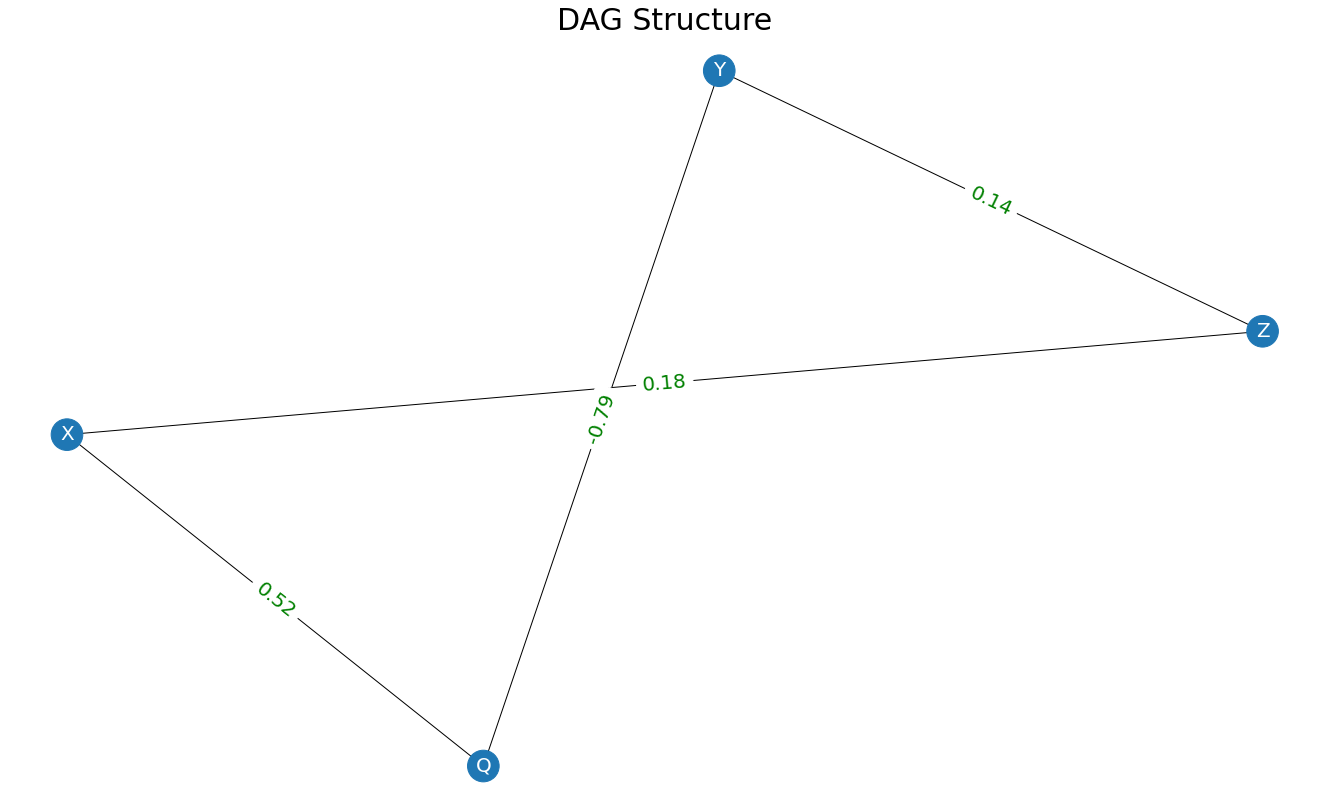

In [9]:
graph_DAG(undirected_graph, df, title = "DAG Structure")

In [10]:
from pgmpy.estimators import PC
c = PC(df)
max_cond_vars = len(dag_keys) - 2


model = c.estimate(return_type = "dag",variant= "parallel", 
                   significance_level = 0.001, 
                   max_cond_vars = max_cond_vars, ci_test = "pearsonr")
edges = model.edges()
pcorr = df.pcorr()
weights = {}
for edge in edges:
    print(edge, ":",pcorr[edge[0]].loc[edge[1]])
    

Working for n conditional variables: 2: 100%|████████████████████████████████████████████| 2/2 [00:00<00:00,  7.67it/s]C:\Users\JLCat\anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 2: 100%|████████████████████████████████████████████| 2/2 [00:00<00:00,  6.00it/s]

('X', 'Z') : 0.18290317846928006
('Y', 'Z') : 0.14073272044202878
('Q', 'Y') : -0.7903464533430554
('Q', 'X') : 0.5232619279593358


('X', 'Z') ['Y', 'Q']
('Y', 'Z') ['X', 'Q']
('Q', 'Y') ['Z']
('Q', 'X') ['Z']


OutEdgeView([('X', 'Z'), ('Y', 'Z'), ('Q', 'Y'), ('Q', 'X')])

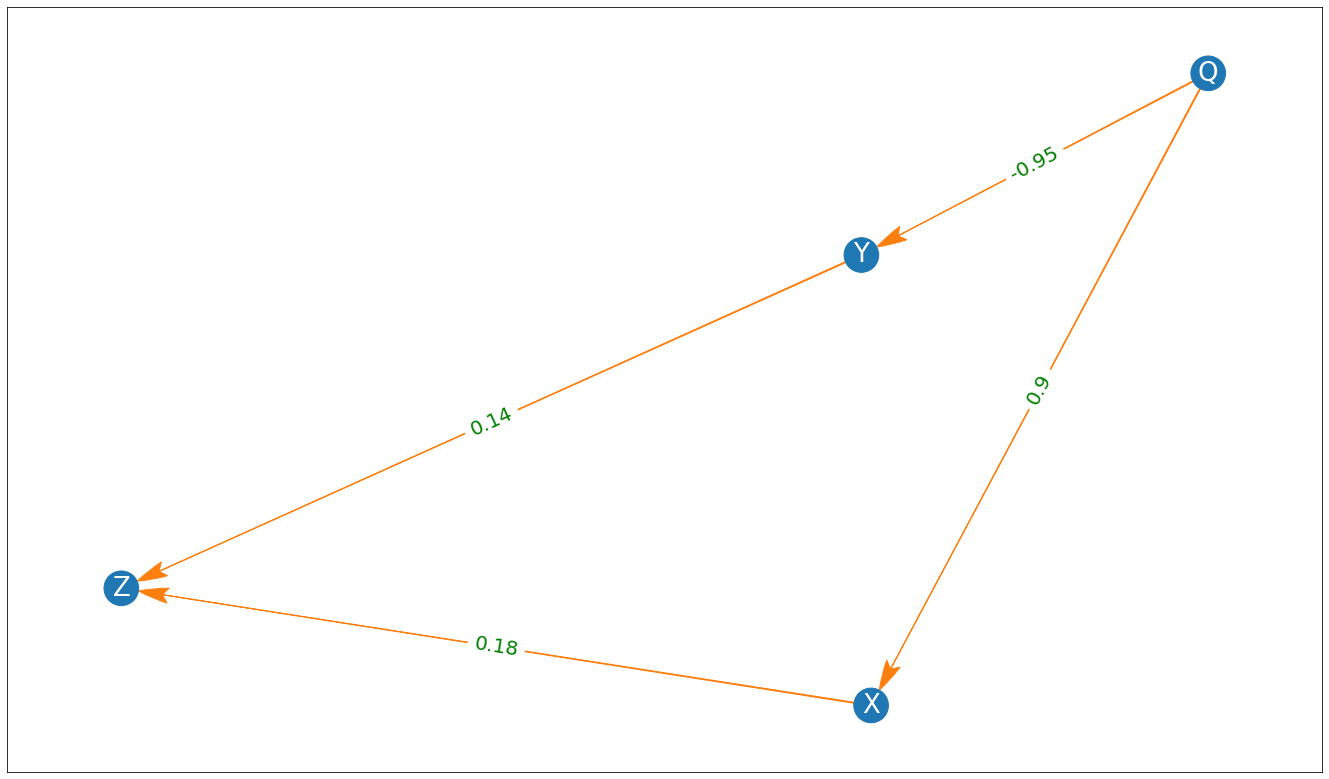

In [21]:
from matplotlib.patches import ArrowStyle

def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    edge_labels = {}
    for edge in edges:
        controls = [key for key in df.keys() if key not in edge]
        controls = list(set(controls))
        for control in controls:
            descendants = []
            remove = True
            for Edge in edges:
                if control == Edge[0]:
                    descendants.append(Edge[1])
            if (edge[0] in descendants or edge[1] in descendants):
                remove = False
            if remove:
                controls.remove(control)
                
        print(edge, controls)
        pcorr = df[[edge[0], edge[1]]+controls].pcorr()
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    nx.draw_networkx_edge_labels(graph,pos,
                                edge_labels=edge_labels,
                                font_color='green',
                                font_size=20)

graph_DAG(edges, df)
edges

In [14]:
df[["X","Y", "Z"]].pcorr()

,X,Y,Z
X,1.000000,-0.857750,0.185802
Y,-0.857750,1.000000,0.291039
Z,0.185802,0.291039,1.000000
